# Gesture Recognition



## Import Libraries

**Explanation**: Importing necessary libraries for data processing, machine learning, visualization, and signal processing. Each library supports various functionalities throughout the notebook.

In [74]:
!pip install imbalanced-learn

import sklearn
import matplotlib
import pandas
import numpy
from imblearn.over_sampling import SMOTE

print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"Numpy version: {numpy.__version__}")
print("SMOTE imported successfully!")


Scikit-learn version: 1.2.2
Matplotlib version: 3.7.2
Pandas version: 2.0.3
Numpy version: 1.24.3
SMOTE imported successfully!


In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import butter, filtfilt, welch
import pywt
from scipy.fft import fft

## Data Filtering Functions and Trimming the Data
**Authorship**: Girija D

**`butter_lowpass_filter`**
This function applies a Butterworth low-pass filter to data to remove high-frequency noise while preserving signals below a specified cutoff frequency. It is essential for ensuring data quality by maintaining only the relevant frequencies and reducing data noise, which is crucial for accurate analysis.

**`trim_and_filter_data` Function :**
This function trims and filters accelerometer data based on defined thresholds of mean plus standard deviation for each axis. It first identifies and removes outlier data that significantly deviates from typical behavior, then applies a low-pass filter to smooth the remaining data. This step is vital for focusing analysis on the most relevant data segments and enhancing signal quality.

## Butterworth Filter Implementation



In [53]:
def butter_lowpass_filter(data, cutoff_frequency, sampling_rate, order=5):
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

## Data Trimming and Filtering



In [54]:
def trim_and_filter_data(data, cutoff_frequency=2, sampling_rate=100):
    thresholds = {
        'Linear Acceleration x (m/s^2)': data['Linear Acceleration x (m/s^2)'].mean() + data['Linear Acceleration x (m/s^2)'].std(),
        'Linear Acceleration y (m/s^2)': data['Linear Acceleration y (m/s^2)'].mean() + data['Linear Acceleration y (m/s^2)'].std(),
        'Linear Acceleration z (m/s^2)': data['Linear Acceleration z (m/s^2)'].mean() + data['Linear Acceleration z (m/s^2)'].std(),
        'Absolute acceleration (m/s^2)': data['Absolute acceleration (m/s^2)'].mean() + data['Absolute acceleration (m/s^2)'].std()
    }
    start_indices = {column: data[data[column] > threshold].index[0] for column, threshold in thresholds.items()}
    end_indices = {column: data[data[column] > threshold].index[-1] for column, threshold in thresholds.items()}
    
    overall_start = min(start_indices.values())
    overall_end = max(end_indices.values())
    
    trimmed_data = data.loc[overall_start:overall_end].copy()
    
    for column in thresholds:
        filtered_column_name = 'Filtered ' + column
        trimmed_data[filtered_column_name] = butter_lowpass_filter(trimmed_data[column], cutoff_frequency, sampling_rate)
    return trimmed_data

## Feature Extraction and Windowing
**Authorship**: Nidhi S

**`sliding_window` Function :**
This function generates overlapping windows from the data, which are essential for time-series analysis in gesture recognition. Each window captures a subset of the data at specified intervals, allowing for detailed and localized analysis of changes over time, crucial for extracting meaningful features from sequences of gestures.

**`wavelet_features` Function :**
Implements wavelet transform to extract features from the data. Wavelet analysis helps in capturing both frequency and location information from the data, making it highly effective for non-stationary signal analysis like human gestures. This function computes statistical measures of the wavelet coefficients to provide insights into the frequency domain characteristics of the data.

**`calculate_features` Function :**
This function processes each window of data to extract a comprehensive set of features. It includes basic statistical measures, zero-crossing rates, Fourier transform peak frequencies, and magnitudes, as well as wavelet-based features. Additionally, it calculates the signal magnitude area (SMA) and vector magnitude (SVM) to summarize overall motion intensity and orientation. These features are crucial for training machine learning models to recognize different gestures accurate

## Generate Overlapping Sliding Windows

The `sliding_window` function generates overlapping sliding windows from the acceleration data.
An Overlap of 50% was implemented.

In [55]:
def sliding_window(data, window_size, overlap_size):
    return [data.iloc[start:start + window_size] for start in range(0, len(data) - window_size + 1, overlap_size)]

## Wavelet-Based Feature Extraction

The `wavelet_features` function extracts features using wavelet decomposition.

In [56]:
def wavelet_features(data):
    features = {}
    coeffs = pywt.wavedec(data, 'db4', level=3)
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_mean_{i}'] = np.mean(coeff)
        features[f'wavelet_std_{i}'] = np.std(coeff)
    return features

## Statistical and Spectral Feature Extraction

The `calculate_features` function extracts statistical,time domain and frequency domain features from the sliding windows.

In [57]:
def calculate_features(windows, sampling_rate):
    features_list = []
    for window in windows:
        features = {}
        acc_x = window['Filtered Linear Acceleration x (m/s^2)']
        acc_y = window['Filtered Linear Acceleration y (m/s^2)']
        acc_z = window['Filtered Linear Acceleration z (m/s^2)']
        
        for axis, data in zip(['x', 'y', 'z'], [acc_x, acc_y, acc_z]):
            features[f'mean_{axis}'] = np.mean(data)
            features[f'std_{axis}'] = np.std(data)
            features[f'min_{axis}'] = np.min(data)
            features[f'max_{axis}'] = np.max(data)
            features[f'skew_{axis}'] = pd.Series(data).skew()
            features[f'kurtosis_{axis}'] = pd.Series(data).kurt()
            
            zero_crossings = len(np.where(np.diff(np.signbit(data)))[0])
            features[f'zcr_{axis}'] = zero_crossings / len(data)
            
            fft_vals = fft(data.values)
            fft_freq = np.fft.fftfreq(len(data), d=1/sampling_rate)
            features[f'fft_peak_freq_{axis}'] = fft_freq[np.argmax(np.abs(fft_vals))]
            features[f'fft_peak_magnitude_{axis}'] = np.max(np.abs(fft_vals))
            freq, power_spectral_density = welch(data, fs=sampling_rate, nperseg=200)
            features[f'spectral_energy_{axis}'] = np.sum(power_spectral_density)
            
        features['sma'] = np.mean(np.abs(acc_x) + np.abs(acc_y) + np.abs(acc_z))
        features['svm'] = np.mean(np.sqrt(acc_x**2 + acc_y**2 + acc_z**2))
        
        features.update(wavelet_features(acc_x))
        features_list.append(features)
        
    return pd.DataFrame(features_list)

## Data Visualization and Model Training
**Authorship**: Arun V S

**`plot_filtered_data_gesture` Function :**
This function visualizes the filtered acceleration data for a specific gesture. It plots time-series graphs for each axis of linear acceleration (X, Y, Z) and the absolute acceleration, using different colors for clarity. The visualization aids in verifying the effectiveness of the data filtering and provides insights into the dynamic characteristics of the gesture, which is crucial for understanding how well the preprocessing steps have prepared the data for model training.

**`plot_gesture_filtered_data` Function :**
Responsible for processing and visualizing filtered gesture data from multiple files within a specified directory. This function automates the retrieval and concatenation of gesture data across different sessions, applies filtering, and then calls `plot_filtered_data_gesture` to display the results. It’s an essential tool for batch processing of gesture data, ensuring that all gesture variations are considered and visualized systematically, which is vital for comprehensive model training and analysis


## Plot Filtered Acceleration Data

The `plot_filtered_data_gesture` function plots filtered acceleration data for a specific gesture.
We use this for plotting a graph for a gesture after filtering the data


In [58]:
def plot_filtered_data_gesture(filtered_data, gesture_name):
    plt.figure(figsize=(12, 8))
    plt.plot(filtered_data['Time (s)'], filtered_data['Filtered Linear Acceleration x (m/s^2)'], label='Filtered Accel X', linestyle='-', color='r')
    plt.plot(filtered_data['Time (s)'], filtered_data['Filtered Linear Acceleration y (m/s^2)'], label='Filtered Accel Y', linestyle='-', color='g')
    plt.plot(filtered_data['Time (s)'], filtered_data['Filtered Linear Acceleration z (m/s^2)'], label='Filtered Accel Z', linestyle='-', color='b')
    plt.plot(filtered_data['Time (s)'], filtered_data['Filtered Absolute acceleration (m/s^2)'], label='Filtered Accel Abs', linestyle='-', color='pink')
    plt.title(f'Trimmed and Filtered Acceleration Data for {gesture_name} Gesture')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Plot One Example per Gesture



In [59]:
def plot_gesture_filtered_data(folder_path):
    gesture_mapping = {'circle': 1, 'wave': 2, 'comeHere': 3, 'goAway': 4}
    for gesture in gesture_mapping.keys():
        gesture_files = glob.glob(os.path.join(folder_path, f'{gesture}*.csv'))
        if gesture_files:
            selected_file = np.random.choice(gesture_files)  # Randomly select one file per gesture
            print(f'Processing file for {gesture}: {selected_file}')
            gesture_data = pd.read_csv(selected_file)
            filtered_data = trim_and_filter_data(gesture_data)
            plot_filtered_data_gesture(filtered_data, gesture)

##  Perform PCA and t-SNE Clustering


In [60]:

def perform_pca_tsne(X, n_components=2):
    pca = PCA(n_components=n_components)
    tsne = TSNE(n_components=n_components, random_state=42)

    pca_result = pca.fit_transform(X)
    tsne_result = tsne.fit_transform(X)

    return pca_result, tsne_result

## Plotting the clusteres

In [61]:
# Plot PCA and t-SNE Clusters
def plot_clusters(data1, data2, labels1, labels2, title1="PCA Clustering", title2="t-SNE Clustering"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)
    colors1 = plt.cm.viridis(np.linspace(0, 1, len(unique_labels1)))
    colors2 = plt.cm.viridis(np.linspace(0, 1, len(unique_labels2)))

    for k, col in zip(unique_labels1, colors1):
        class_mask = (labels1 == k)
        ax[0].scatter(data1[class_mask, 0], data1[class_mask, 1], c=[col], label=f'Cluster {k}')
    ax[0].set_title(title1)
    ax[0].legend()

    for k, col in zip(unique_labels2, colors2):
        class_mask = (labels2 == k)
        ax[1].scatter(data2[class_mask, 0], data2[class_mask, 1], c=[col], label=f'Cluster {k}')
    ax[1].set_title(title2)
    ax[1].legend()

    plt.show()


# Joint Contributions: Data Normalization, Feature Selection, and Ensemble Techniques
**Authorship**: All Members

Implemented data normalization and standardization to make the data suitable for modeling. The Recursive Feature Elimination (RFE) and elbow method are used for feature selection to improve model performance.

**`normalize_and_standardize` Function Explanation:**
This function first normalizes the data using MinMax scaling, bringing all features into the range. It then standardizes these normalized values using a StandardScaler, which adjusts the data to have a mean of zero and a standard deviation of one. This two-step process prepares the data for effective modeling by ensuring all features contribute equally, preventing any single feature with larger values from dominating the model training process.

**`feature_selection_rfe` Function:**
Implements Recursive Feature Elimination (RFE) using a specified machine learning model to identify the most important features for the model. RFE works by recursively removing the least important features (as judged by the model) until the desired number of features is reached. This method helps improve model performance by eliminating irrelevant or less important features, focusing the model on the data aspects that most strongly predict the target variable.

**`elbow_method_feature_selection` Function:**
This function applies the elbow method to determine the optimal number of features for the model. It involves running RFE for different numbers of features and plotting the model's cross-validation score against the number of features used. The 'elbow' point in the plot, where the increase in the number of features does not result in significant improvement in performance, suggests the optimal number of features to use. This technique aids in selecting the most effective yet concise feature set for the model.

**`train_and_evaluate_model` Function:**
Trains and evaluates a machine learning model using GridSearchCV to find the best parameter combinations. This function splits the data into training and test sets, applies grid search to explore different configurations, and evaluates the model using cross-validation. It reports the best parameters found, cross-validation scores, and test accuracy, providing a comprehensive view of the model's performance and suitability for making predictions on new, unseen data.

**`process_files_from_folder` Function:**
Processes gesture data files from a specified folder, applying data preprocessing, feature extraction, and compilation into a single DataFrame. For each gesture type, it reads all corresponding files, filters the data, and extracts relevant features using a sliding window approach. This comprehensive function is crucial for preparing the dataset for subsequent modeling, ensuring that all data undergoes consistent preprocessing and feature extraction steps.


## Normalize and Standardize Features



In [62]:
def normalize_and_standardize(data):
    normalizer = MinMaxScaler()
    scaler = StandardScaler()
    normalized_data = normalizer.fit_transform(data)
    standardized_data = scaler.fit_transform(normalized_data)
    return standardized_data

## Recursive Feature Elimination (RFE)



In [63]:
def feature_selection_rfe(X, y, model, feature_names, num_features=3):
    from sklearn.feature_selection import RFE
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    X_rfe = rfe.fit_transform(X, y)
    selected_features_indices = np.where(rfe.support_)[0]
    selected_features_names = [feature_names[i] for i in selected_features_indices]
    return X_rfe, rfe, selected_features_names

## Elbow Method for Feature Selection



In [64]:
def elbow_method_feature_selection(X, y, model, feature_names):
    scores = []
    num_features_range = range(1, X.shape[1] + 1)
    selected_features_list = []
    for num_features in num_features_range:
        X_rfe, _, selected_features_names = feature_selection_rfe(X, y, model, feature_names, num_features=num_features)
        cv_score = cross_val_score(model, X_rfe, y, cv=5).mean()
        scores.append(cv_score)
        selected_features_list.append((num_features, selected_features_names))
    plt.plot(num_features_range, scores, 'o-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score')
    plt.title('Elbow Method for Feature Selection')
    plt.grid(True)
    plt.show()
    return selected_features_list

## Train and Evaluate Models



In [65]:
def train_and_evaluate_model(model, param_grid, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f'Best parameters found: {grid_search.best_params_}')

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=10)
    print(f'Cross-validation scores: {cv_scores}')
    print(f'Mean cross-validation score: {np.mean(cv_scores):.3f}')

    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Test Accuracy: {test_accuracy:.3f}')

    y_pred = best_model.predict(X_test)
    print(f'Classification Report for Test Data:\n{classification_report(y_test, y_pred)}')
    return best_model, test_accuracy

## Process Files from a Folder

The `process_files_from_folder` function processes files from a folder to extract features.

In [66]:
def process_files_from_folder(folder_path):
    gesture_mapping = {'circle': 1, 'wave': 2, 'comeHere': 3, 'goAway': 4}
    all_features = []
    for gesture, label in gesture_mapping.items():
        gesture_files = glob.glob(os.path.join(folder_path, f'{gesture}*.csv'))
        for file in gesture_files:
            print(f"Processing file: {file}")
            raw_data = pd.read_csv(file)
            filtered_data = trim_and_filter_data(raw_data)
            filtered_data.reset_index(inplace=True, drop=True)
            window_length_seconds = 2
            sampling_rate = 100
            window_size = window_length_seconds * sampling_rate
            overlap_size = window_size // 2
            windows = sliding_window(filtered_data, window_size, overlap_size)
            features_df = calculate_features(windows, sampling_rate)
            features_df['gesture'] = label
            all_features.append(features_df)
    combined_features_df = pd.concat(all_features, ignore_index=True)
    return combined_features_df

## Main Execution

This section runs the main execution pipeline for gesture recognition.

Processing file for circle: ../Datasets\circle23.csv


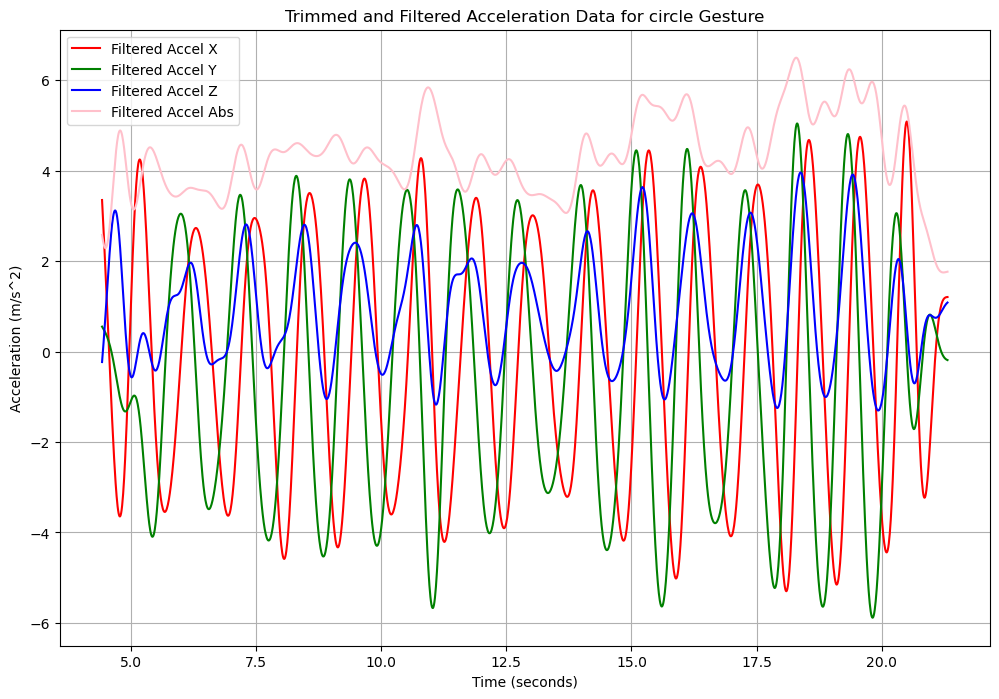

Processing file for wave: ../Datasets\wave27.csv


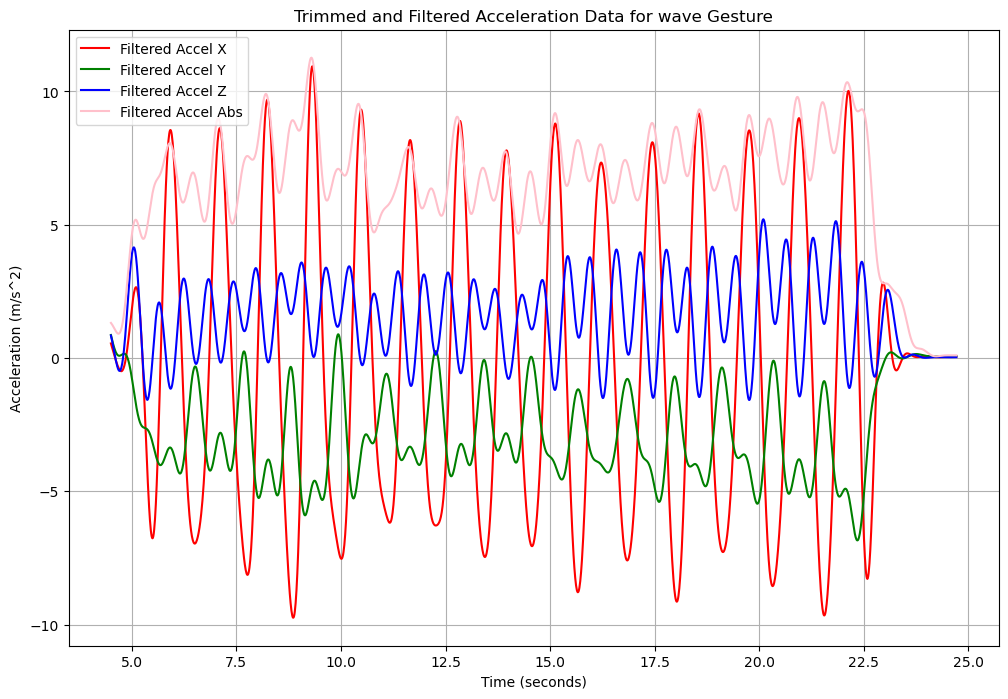

Processing file for comeHere: ../Datasets\comeHere4.csv


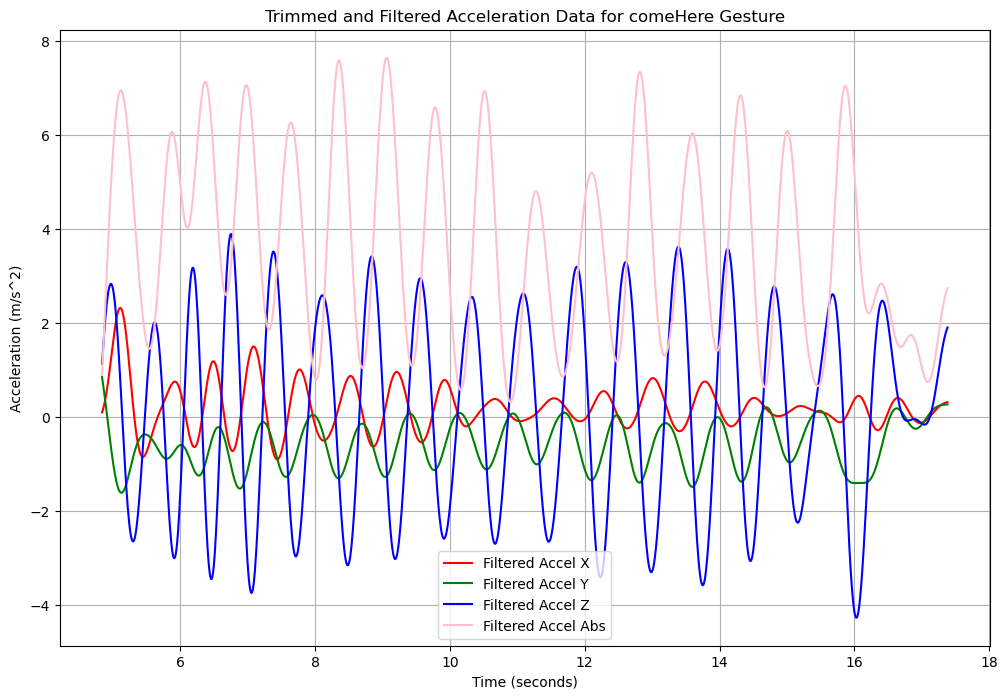

Processing file for goAway: ../Datasets\goAway26.csv


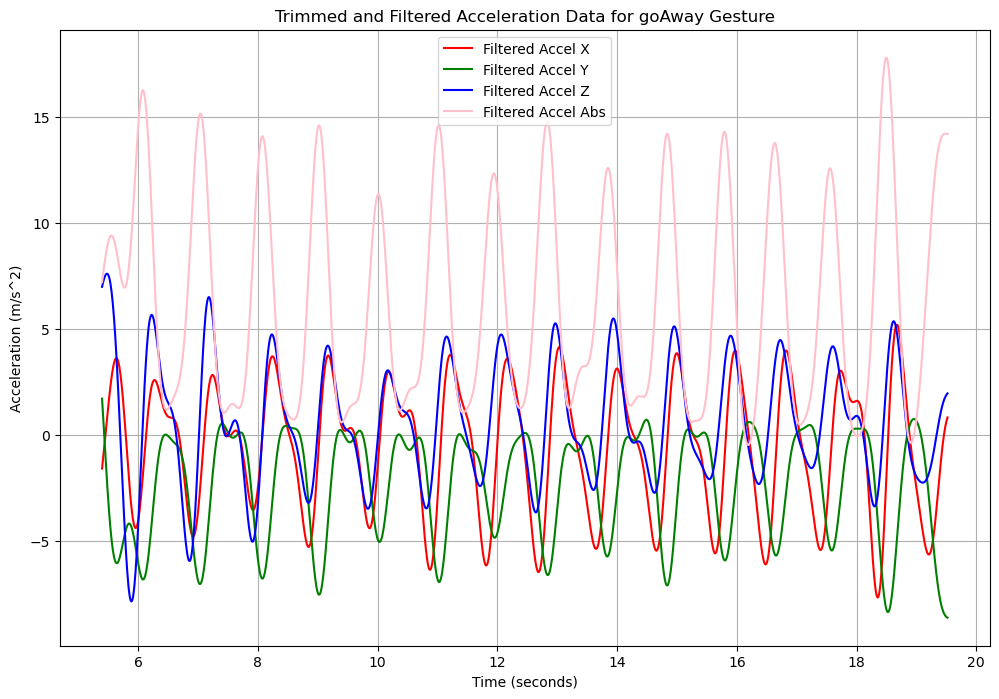

Processing file: ../Datasets\circle1.csv
Processing file: ../Datasets\circle10.csv
Processing file: ../Datasets\circle11.csv
Processing file: ../Datasets\circle12.csv
Processing file: ../Datasets\circle13.csv
Processing file: ../Datasets\circle14.csv
Processing file: ../Datasets\circle15.csv
Processing file: ../Datasets\circle16.csv
Processing file: ../Datasets\circle17.csv
Processing file: ../Datasets\circle18.csv
Processing file: ../Datasets\circle19.csv
Processing file: ../Datasets\circle2.csv
Processing file: ../Datasets\circle20.csv
Processing file: ../Datasets\circle21.csv
Processing file: ../Datasets\circle22.csv
Processing file: ../Datasets\circle23.csv
Processing file: ../Datasets\circle24.csv
Processing file: ../Datasets\circle25.csv
Processing file: ../Datasets\circle26.csv
Processing file: ../Datasets\circle27.csv
Processing file: ../Datasets\circle28.csv
Processing file: ../Datasets\circle29.csv
Processing file: ../Datasets\circle3.csv
Processing file: ../Datasets\circle30

C:\Users\91790\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91790\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


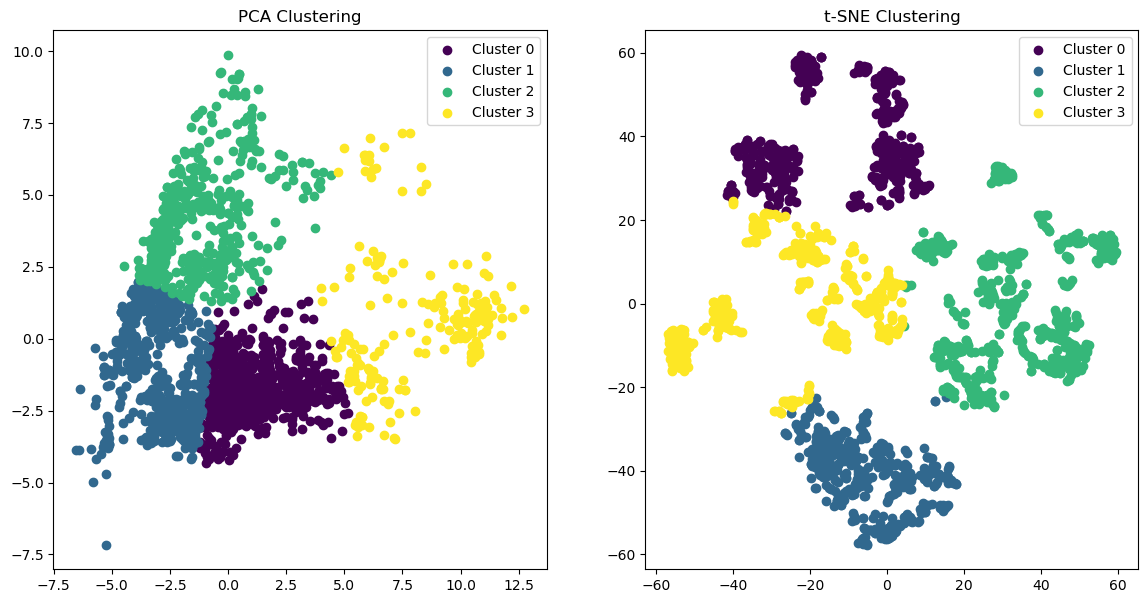

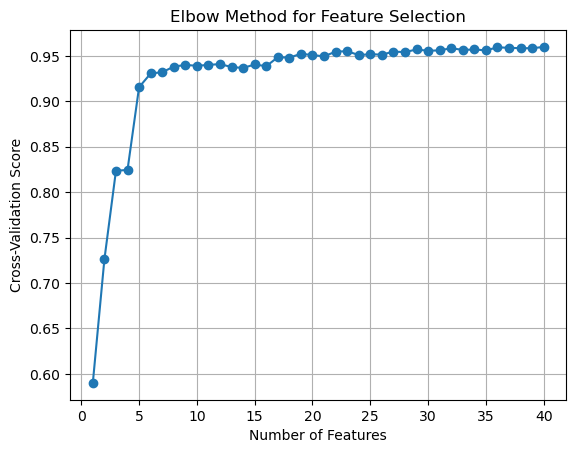

Selected Features: ['std_x', 'fft_peak_magnitude_x', 'mean_y', 'std_z']

Logistic Regression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation scores: [0.83221477 0.83221477 0.80536913 0.88590604 0.84459459 0.81081081
 0.88513514 0.83108108 0.83783784 0.85135135]
Mean cross-validation score: 0.842
Training Accuracy: 0.842
Test Accuracy: 0.838
Classification Report for Test Data:
              precision    recall  f1-score   support

           1       0.87      0.93      0.90       159
           2       0.75      0.90      0.82       159
           3       0.92      0.99      0.95       159
           4       0.81      0.53      0.64       159

    accuracy                           0.84       636
   macro avg       0.84      0.84      0.83       636
weighted avg       0.84      0.84      0.83       636


RandomForestClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [67]:
if __name__ == '__main__':
    folder_path = '../Datasets' #the datasets should be in the root folder
    plot_gesture_filtered_data(folder_path)
    combined_features_df = process_files_from_folder(folder_path)
    feature_data = combined_features_df.drop('gesture', axis=1).values
    feature_names = combined_features_df.drop('gesture', axis=1).columns
    labels = combined_features_df['gesture'].values
    standardized_feature_data = normalize_and_standardize(feature_data)
    
    

    smote = SMOTE(random_state=42)
    smote_features, smote_labels = smote.fit_resample(standardized_feature_data, labels)
    # PCA and t-SNE Clustering
    pca_result, tsne_result = perform_pca_tsne(smote_features)
    n_clusters = len(np.unique(smote_labels))
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42)

    pca_labels = kmeans_pca.fit_predict(pca_result)
    tsne_labels = kmeans_tsne.fit_predict(tsne_result)

    # Plot Clusters
    plot_clusters(pca_result, tsne_result, pca_labels, tsne_labels)
    logistic_regression_model = LogisticRegression(max_iter=200, random_state=42)
    selected_features_list = elbow_method_feature_selection(smote_features, smote_labels, logistic_regression_model, feature_names)
    
    selected_features, rfe, selected_features_names = feature_selection_rfe(smote_features, smote_labels, logistic_regression_model, feature_names, num_features=4)
    print(f"Selected Features: {selected_features_names}")

    results = []

    print("\nLogistic Regression")
    logistic_regression_param_grid = {
        'C': [0.001, 0.01, 0.1],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
    }
    logistic_regression_best_model, logistic_regression_test_acc = train_and_evaluate_model(LogisticRegression(max_iter=200, random_state=42), logistic_regression_param_grid, selected_features, smote_labels)
    results.append({'Model': 'Logistic Regression', 'Test Accuracy': logistic_regression_test_acc})

    print("\nRandomForestClassifier")
    random_forest_param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5],
        'min_samples_split': [5],
        'min_samples_leaf': [2, 4],
        'max_features': ['sqrt']
    }
    random_forest_best_model, random_forest_test_acc = train_and_evaluate_model(RandomForestClassifier(random_state=42), random_forest_param_grid, selected_features, smote_labels)
    results.append({'Model': 'Random Forest', 'Test Accuracy': random_forest_test_acc})

    print("\nGradientBoostingClassifier")
    gradient_boosting_param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.001, 0.01],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }
    gradient_boosting_best_model, gradient_boosting_test_acc = train_and_evaluate_model(GradientBoostingClassifier(random_state=42), gradient_boosting_param_grid, selected_features, smote_labels)
    results.append({'Model': 'Gradient Boosting', 'Test Accuracy': gradient_boosting_test_acc})

    print("\nAdaBoostClassifier")
    adaboost_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.001, 0.01, 0.05]
    }
    adaboost_best_model, adaboost_test_acc = train_and_evaluate_model(AdaBoostClassifier(random_state=42), adaboost_param_grid, selected_features, smote_labels)
    results.append({'Model': 'AdaBoost', 'Test Accuracy': adaboost_test_acc})

    print("\nSupport Vector Classifier (SVC)")
    svc_param_grid = {
        'C': [0.001, 0.01, 0.1],
        'kernel': ['linear', 'rbf']
    }
    svc_best_model, svc_test_acc = train_and_evaluate_model(SVC(random_state=42), svc_param_grid, selected_features, smote_labels)
    results.append({'Model': 'SVC', 'Test Accuracy': svc_test_acc})

    # Create a DataFrame with all results
    results_df = pd.DataFrame(results)
    print("\nModel Performance Comparison:")
    print(results_df)

    # Identify and print the best model
    best_model_row = results_df.loc[results_df['Test Accuracy'].idxmax()]
    print(f"\nBest Model: {best_model_row['Model']} with Test Accuracy: {best_model_row['Test Accuracy']:.3f}")